In [27]:
onedrive = r"C:\Users\mikek\OneDrive"

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray as xr
import xbout
from pathlib import Path

sys.path.append(os.path.join(onedrive,r"Project\python-packages\sdtools"))

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.fluxes import *


%load_ext autoreload
%autoreload 2


print("Done")

C:\Users\mikek\OneDrive\Project\python-packages\xBOUT\xbout\boutdataset.py:38: AccessorRegistrationWarning: registration of accessor <class 'xbout.boutdataset.BoutDatasetAccessor'> under name 'bout' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class BoutDatasetAccessor:
C:\Users\mikek\OneDrive\Project\python-packages\xBOUT\xbout\boutdataarray.py:26: AccessorRegistrationWarning: registration of accessor <class 'xbout.boutdataarray.BoutDataArrayAccessor'> under name 'bout' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  class BoutDataArrayAccessor:


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


# IO

In [28]:
db = CaseDB()

choice = "x-b3-neut_p_n_free_bc"
# choice = "c1a-40eV_1e17_newbout"
# choice = "b1et2_3.08re6_fr0.85"
# choice = "b3a-t3-small_temp_steps"

case, caseng = Load.case_2D(db.casepaths[choice], gridfilepath = db.gridpaths["g3b1-lores_newhypno.nc"],
                    double_load = True)

False
False
--> dx, dy and J will not be unnormalised
CHECK: Total domain volume is 1.348E+08 [m3]
--> dx, dy and J will not be unnormalised
CHECK: Total domain volume is 8.658E+07 [m3]


In [18]:
%matplotlib widget

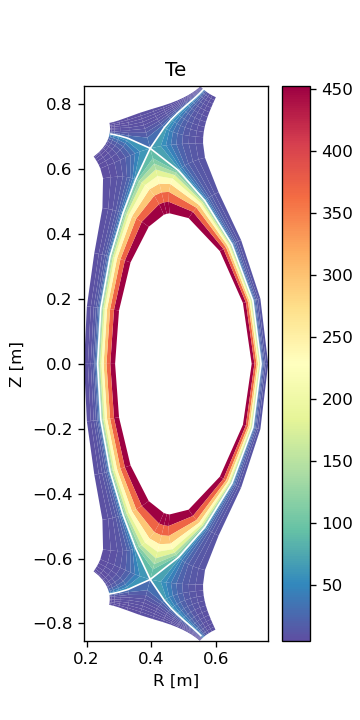

In [26]:
caseng.ds["Te"].isel(t=-1).bout.polygon(antialias = True, cmap = "Spectral_r", linecolor = "black")

# Dev

In [27]:
bd = caseng.ds
a = caseng.ds["Ne"]*Chi
f = constants("q_e") * caseng.ds["Td+"]

J = bd["J"] # Jacobian
g11 = bd["g11"]
dx = bd["dx"]
dy = bd["dy"]
dz = bd["dz"]

F_R = xr.zeros_like(f) # Flux to the right
F_L = xr.zeros_like(f) # Flux from the left

grad = []

#x is current, xp is next
for x in bd.x[:-1]:
    xp = x + 1  # The next X cell
    # Note: Order of array operations matters for shape of the result
    gradient = f.isel(x=xp) - f.isel(x=x)
    gradient = (f.isel(x=xp) - f.isel(x=x)) * (J.isel(x=x) * g11.isel(x=x) + J.isel(x=xp) * g11.isel(x=xp)) / (dx.isel(x=x) + dx.isel(x=xp))
    

    flux = -gradient * 0.5*(a.isel(x=x) + a.isel(x=xp))
    """OK"""
    
    # if gradient > 0:
        # Flow from x+1 to x
        # flux = -gradient * a.isel(x=xp)  # Note: Negative flux = flow into this cell from right
#     # else:
#     #     # Flow from x to x+1
#     #     flux = -gradient * a.isel(x=x)  # Positive flux => Flow from this cell to the right

#     # Need to multiply by dy * dz because these are assumed constant in X in the calculation
#     # of flux and cell volume.
#     flux *= dy.isel(x=x) * dz.isel(x=x)

    F_R[dict(x=x)] = flux
    F_L[dict(x=xp)] = flux
    
    # F_R[dict(x=x)] = gradient
    # F_L[dict(x=xp)] = gradient

- Gradient is OK

In [90]:
ds = caseng.ds
a = caseng.ds["Ne"]*Chi
f = constants("q_e") * caseng.ds["Td+"]

F_L, F_R         = Div_a_Grad_perp_upwind(ds, a, f)

Text(0.5, 1.0, 'Poloidal integral of heat flux across entire domain')

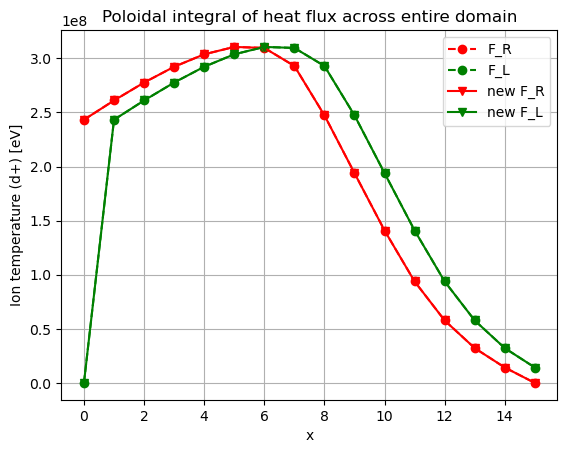

In [91]:
new_F_L, new_F_R = Div_a_Grad_perp_upwind_fast(ds, a, f)

fig, ax = plt.subplots()
F_R.isel(t=-1).sum("theta").plot(ax = ax, label = "F_R", marker = "o", c = "red", ls = "--")
F_L.isel(t=-1).sum("theta").plot(ax = ax, label = "F_L", marker = "o", c = "green", ls = "--")

new_F_R.isel(t=-1).sum("theta").plot(ax = ax, label = "new F_R", marker = "v", c = "red")
new_F_L.isel(t=-1).sum("theta").plot(ax = ax, label = "new F_L", marker = "v", c = "green")
ax.legend()
ax.grid()
ax.set_title("Poloidal integral of heat flux across entire domain")

# Testing

In [88]:
import time

start = time.time()

diff1 = Div_a_Grad_perp_upwind(caseng.ds, caseng.ds["Ne"]*Chi, constants("q_e") * caseng.ds["Td+"])

a = time.time()

diff2 = Div_a_Grad_perp_upwind_fast(caseng.ds, caseng.ds["Ne"]*Chi, constants("q_e") * caseng.ds["Td+"])

b = time.time()

print(f"{a-start}")
print(f"{a-b}")
print(f"{(a-start)/(a-b)}")


5.461061954498291
-0.029786109924316406
-183.3425703582749


In [84]:
Chi = 3
D = 1

diff1 = Div_a_Grad_perp_upwind(caseng.ds, caseng.ds["Ne"]*Chi, constants("q_e") * caseng.ds["Td+"])
diff2 = Div_a_Grad_perp_upwind_fast(caseng.ds, caseng.ds["Ne"]*Chi, constants("q_e") * caseng.ds["Td+"])

conv1 = Div_a_Grad_perp_upwind(caseng.ds, (constants("q_e") * caseng.ds["Td+"])*D, caseng.ds["Ne"])
conv2 = Div_a_Grad_perp_upwind_fast(caseng.ds, (constants("q_e") * caseng.ds["Td+"])*D, caseng.ds["Ne"])

total1 = diff1[1] + conv1[1]
total2 = diff2[1] + conv2[1]

In [93]:
fluxes = pd.DataFrame()

for ring_id in range(10):
    
    fluxes.loc[ring_id, "conv1"] = conv1[1].hermes.select_custom_core_ring(ring_id).sum("theta").isel(t=-1).values.squeeze()
    fluxes.loc[ring_id, "conv2"] = conv2[1].hermes.select_custom_core_ring(ring_id).sum("theta").isel(t=-1).values.squeeze()
    fluxes.loc[ring_id, "diff1"] = diff1[1].hermes.select_custom_core_ring(ring_id).sum("theta").isel(t=-1).values.squeeze()
    fluxes.loc[ring_id, "diff2"] = diff2[1].hermes.select_custom_core_ring(ring_id).sum("theta").isel(t=-1).values.squeeze()
    fluxes.loc[ring_id, "Rd+_ex"] = caseng.ds["Rd+_ex"].hermes.select_custom_core_ring(ring_id).sum("theta").isel(t=-1).values.squeeze()

    
fluxes["total1"] = fluxes["conv1"] + fluxes["conv1"]
fluxes["total2"] = fluxes["conv2"] + fluxes["conv2"]
#     convective.append(co[1].hermes.select_custom_core_ring(ring_id).sum("theta").isel(t=-1).values)
#     diffusive.append(diffusive_heat_flux[1].hermes.select_custom_core_ring(ring_id).sum("theta").isel(t=-1).values)
#     radiation.append(caseng.ds["Rd+_ex"].hermes.select_custom_core_ring(ring_id).sum("theta").isel(t=-1).values)

# convective = np.array(convective).squeeze()
# diffusive = np.array(diffusive).squeeze()
# total = convective + diffusive
# radiation = np.array(radiation).squeeze()

# fluxes

## Radial evolution

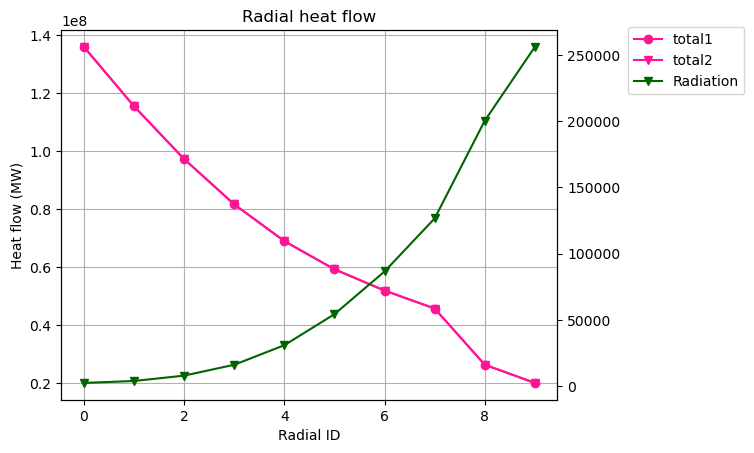

In [100]:
fig, ax = plt.subplots()

# ax.plot(fluxes.index, fluxes["conv1"], c = "navy", marker="o", label = "conv1")
# ax.plot(fluxes.index, fluxes["conv2"], c = "navy", marker="v", label = "conv2")

# ax.plot(fluxes.index, fluxes["diff1"], c = "orange", marker="o", label = "diff1")
# ax.plot(fluxes.index, fluxes["diff2"], c = "orange", marker="v", label = "diff2")

ax.plot(fluxes.index, fluxes["total1"], c = "deeppink", marker="o", label = "total1")
ax.plot(fluxes.index, fluxes["total2"], c = "deeppink", marker="v", label = "total2")



# ax.plot(range(19), convective, c = "darkorange", marker="o", label = "convective")
# ax.plot(range(19), total.squeeze(), c = "deeppink", marker="o", label = "total")
ax2 = ax.twinx()
ax2.plot(fluxes.index, fluxes["Rd+_ex"]*-1, c = "darkgreen", marker="v", label = "Radiation")
ax.set_title("Radial heat flow")
ax.set_xlabel("Radial ID")
ax.set_ylabel("Heat flow (MW)")
fig.legend(loc = "upper left", bbox_to_anchor=(1,0.9))
ax.grid()

In [10]:
ds = caseng.ds

name = "e"

L, R  =  Div_a_Grad_perp_upwind_fast(ds, ds[f"N{name}"] * ds[f"anomalous_Chi_{name}"], constants("q_e") * ds[f"T{name}"])
ds[f"hf_perp_diff_L_{name}"] = L 
ds[f"hf_perp_diff_R_{name}"] = R

L, R  =  Div_a_Grad_perp_upwind_fast(ds, constants("q_e") * ds[f"T{name}"] * ds[f"anomalous_D_{name}"], ds[f"N{name}"])
ds[f"hf_perp_conv_L_{name}"] = L 
ds[f"hf_perp_conv_R_{name}"] = R

ds[f"hf_perp_tot_L_{name}"] = ds[f"hf_perp_conv_L_{name}"] + ds[f"hf_perp_diff_L_{name}"]
ds[f"hf_perp_tot_R_{name}"] = ds[f"hf_perp_conv_R_{name}"] + ds[f"hf_perp_diff_R_{name}"]

L, R  =  Div_a_Grad_perp_upwind_fast(ds, ds[f"anomalous_D_{name}"] * ds[f"N{name}"] / ds[f"N{name}"], ds[f"N{name}"])
ds[f"pf_perp_diff_L_{name}"] = L 
ds[f"pf_perp_diff_R_{name}"] = R

# conv1 = Div_a_Grad_perp_upwind(caseng.ds, (constants("q_e") * caseng.ds["Td+"])*D, caseng.ds["Ne"])
# conv2 = Div_a_Grad_perp_upwind_fast(caseng.ds, (constants("q_e") * caseng.ds["Td+"])*D, caseng.ds["Ne"])

## Time evolution on first ring

In [5]:
from hermes3.fluxes import *

ds = calculate_fluxes(caseng.ds)

fig, ax = plt.subplots()

(ds["hf_perp_tot_R_d+"].sum("theta").isel(x = 0) /1e6).plot(ax = ax, c = "navy", label = "Ions")
(ds["hf_perp_tot_R_e"].sum("theta").isel(x = 0) /1e6).plot(ax = ax, c = "darkorange", label = "Electrons")
# convective_heat_flux[1].sum("theta").isel(x = 3).plot(ax = ax, c = "darkorange", label = "convective")
# total_heat_flux.sum("theta").isel(x = 3).plot(ax = ax, c = "deeppink", label = "total")

ax.legend()
ax.grid()

KeyError: 'anomalous_Chi_d'

In [16]:
charged_species = [x for x in caseng.ds.metadata["species"] if "e" in x or "+" in x]
charged_species

['d+', 'e']

In [13]:
caseng.ds.options["d+"]["anomalous_D"]

1

In [22]:
caseng.derive_vars()

In [21]:
ds = caseng.ds

set(ds.metadata["species"]).difference(set(ds.metadata["charged_species"]))

{'d'}

In [1]:
fig, ax = plt.subplots()

(ds["pf_perp_tot_R_d+"].sum("theta").isel(x = 0) /1e6).plot(ax = ax, c = "navy", label = "Ions")
(ds["pf_perp_tot_R_e"].sum("theta").isel(x = 0) /1e6).plot(ax = ax, c = "darkorange", label = "Electrons")
# convective_heat_flux[1].sum("theta").isel(x = 3).plot(ax = ax, c = "darkorange", label = "convective")
# total_heat_flux.sum("theta").isel(x = 3).plot(ax = ax, c = "deeppink", label = "total")

ax.legend()
ax.grid()

NameError: name 'plt' is not defined